The goal of this script is to reproduce the plots in slide 13 of Rama's following presentation:

https://indico.in2p3.fr/event/18281/contributions/72166/attachments/54530/71499/HLLHC_SPSTests_Calaga_EICUserMeeting.pdf

In [15]:
import glob
from headtail.modules import bqht
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.gridspec as grd
import datetime

ModuleNotFoundError: No module named 'headtail'

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 23,
          'axes.titlesize': 23,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 10,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [3]:
def prep_file(name):
    htf = ht.open_file(f'{name}')
    htf.locate_bunches()
    htf.optimise_overlap()
    htf.remove_baseline = False # Don't remove baseline
    htf.align = True            # Get aligned to the same X points
    return htf

In [4]:
# baseline is the first part of the cycle when the CC are not synchronized yet with the RF.
def calc_means(htf, N): # not used here
    pts = int(htf.horizontal.sigma.samples_per_bunch) # slices
    M = int(htf.horizontal.sigma.number_of_turns/N)
    print(M)
    means_delta = []
    means_sigma = []
    for i in range(N):
        mean_delta = np.zeros(pts)
        mean_sigma = np.zeros(pts)
        for j in range(M):
            x, y = htf.vertical.sigma[i*M+j,0]
            mean_sigma += y
            x, y = htf.vertical.delta[i*M+j,0]
            mean_delta += y
        mean_delta /= M
        mean_sigma /= M
        means_delta.append(mean_delta)
        means_sigma.append(mean_sigma)
    return (np.array(means_sigma), np.array(means_delta))

In [5]:
def getOrbitResponse():
    # Bring in relevant optics parameters to calculate orbit response
    # at location of HT monitor from CC kick

    PAY = 8.230968*(2*np.pi) #Slide 16 of Hannes' JUAS
    beta_cc = 64.776662
    beta_ht = 49.434524
    total_Q = 26.18

    orbitResponse1 = np.sqrt(beta_ht)/(2*np.sin(np.pi*total_Q)) #slide 42 of Hannes' JUAS
    orbitResponse2 = np.sqrt(beta_cc)*np.cos(np.pi*total_Q - PAY)
    orbitResponse = orbitResponse1*orbitResponse2
    return orbitResponse


def getHTtraces(sigma, delta):
    
    mid = np.argmax(sigma[-1]) # identical with sigma[0]
    a = mid - 12
    b = mid + 13

    #plot(x, sigma[-1][a:b] * 8 - 0.4, c=color, ls=linestyle)
    #calculate amplitude scaling factor to ensure result is in MV (from mm)

    normPositionFactor = 0.1052 #This factor comes from T. Levens and was measured in 2017
    amp_factor = 1/(normPositionFactor)      #1e-6 is for V to MV
    
    signal = (delta[-1] - delta[0])[a:b] / sigma[-1][a:b]
    return signal*amp_factor, sigma[-1][a:b]

def yGauss(x):
    sig = 2.22 #mm
    intensity = 1
    return intensity/(sig*np.sqrt(2*np.pi))*np.exp(-x*x/(2*sig*sig))

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


In [9]:
# Create a new instance ands set the system to SPS
ht = bqht.BQHT(system='SPS')
# Select a file to use
dataDir = './h5_files/30May2018/'
files = sorted(glob.glob(dataDir+'/*.h5'))
print(files)
name = files[0]

NameError: name 'bqht' is not defined

In [7]:
htf_0 = prep_file(name)  # stracture: htf_0.data.horizontal.delta[turns, bunches]['time', 'value']

NameError: name 'name' is not defined

In [8]:
Delta_H, Delta_V, Sigma = htf_0.horizontal.delta,  htf_0.vertical.delta, htf_0.vertical.sigma # Identical with htf_0.horizontal.sigma  

NameError: name 'htf_0' is not defined

In [15]:
n_bunches = htf_0.bunches
bunch = n_bunches[0]
n_populated_turns = htf_0.horizontal.delta.number_of_turns # the actual number is 5 (4 is the index)
n_slices = htf_0.horizontal.delta.samples_per_bunch # integer is used (round to lower number)
print(f'Bunhes {n_bunches}, Slices {n_slices}, Selected bunch {bunch} \nPopulated turns {n_populated_turns}')

Bunhes [0], Slices 249.5887445887446, Selected bunch 0 
Populated turns 40000


In [17]:
# lists that are ordered with turns 
Delta_V_values, Delta_H_values, Sigma_values = [], [], []

Delta_V_time = Delta_V[int(0), bunch][0] # time is same for all turns [25 ns slots]. Here turn 0 is used abritrary
Delta_H_time = Delta_H[int(0), bunch][0]
Sigma_time = Sigma[int(0), bunch][0]

turns_list = np.linspace(0, n_populated_turns, n_populated_turns, dtype=int)

for turn in turns_list:
    Delta_V_values.append(Delta_V[int(turn), bunch][1])
    Delta_H_values.append(Delta_H[int(turn), bunch][1])
    Sigma_values.append(Sigma[int(turn), bunch][1])

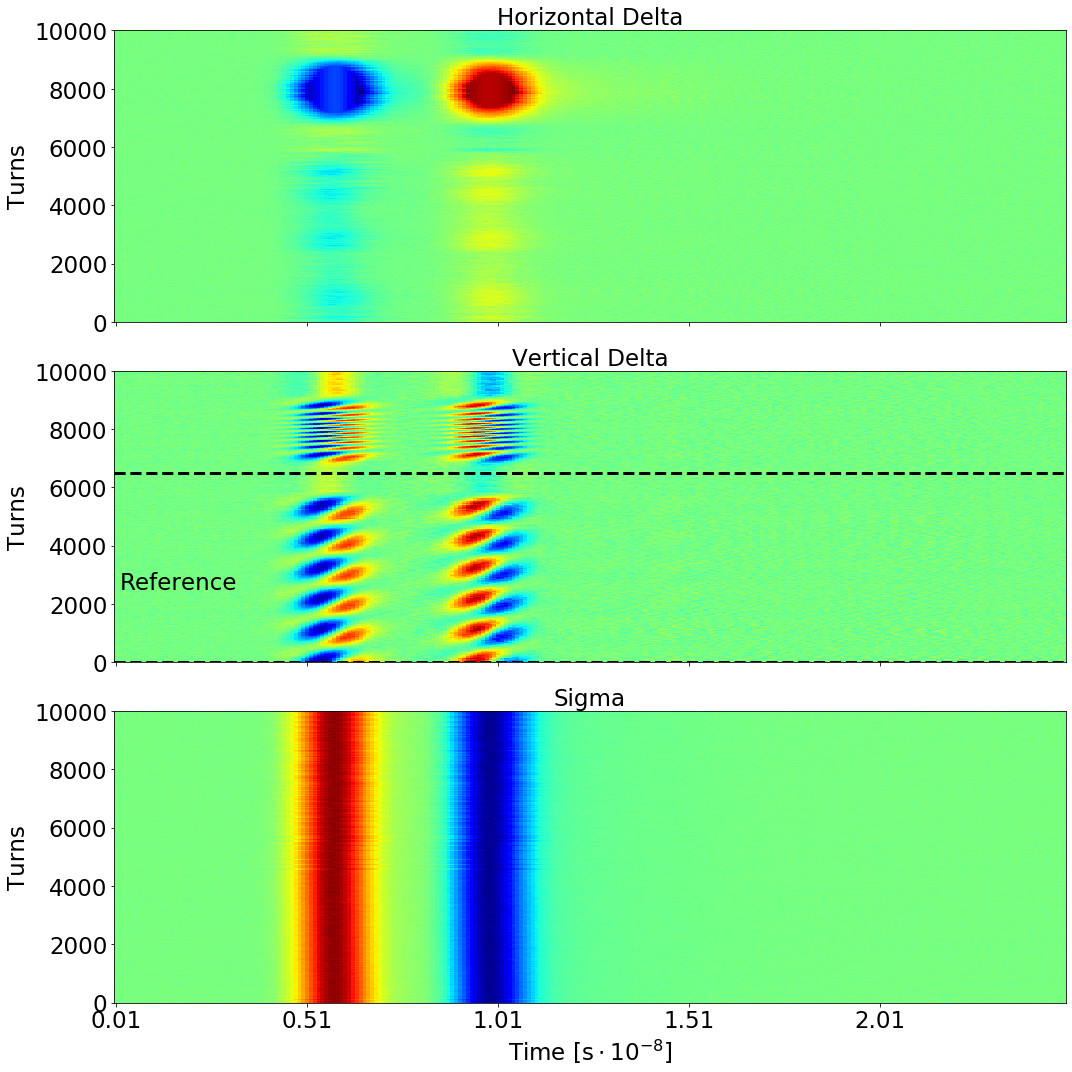

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(15,15)) 
ax[0].imshow(Delta_H_values,  aspect='auto')
ax[1].imshow(Delta_V_values,  aspect='auto')
ax[2].imshow(Sigma_values,  aspect='auto')

# Tick labels
my_ticks = list(np.arange(len(Sigma_time)))
plt.setp(ax[0], xticks=my_ticks[::50], xticklabels=[])
plt.setp(ax[1], xticks=my_ticks[::50], xticklabels=[])
plt.setp(ax[2], xticks=my_ticks[::50], xticklabels=Sigma_time[::50]*1e8)


ylim = 10000 # n_populated_turns
#ax[0].set_ylim(0, n_poputated_turns)
#ax[1].set_ylim(0, n_poputated_turns)
#ax[2].set_ylim(0, n_poputated_turns)

ax[0].set_ylim(0, ylim)
ax[1].set_ylim(0, ylim)
ax[2].set_ylim(0, ylim)


# Titles
ax[0].set_title('Horizontal Delta')
ax[1].set_title('Vertical Delta')
ax[2].set_title('Sigma')

# Axis Labels
ax[0].set_ylabel('Turns')
ax[1].set_ylabel('Turns')
ax[2].set_ylabel('Turns')

ax[2].set_xlabel(r'$\mathrm{Time \ [s \cdot 10^{-8}]}$')


### Plot lines for reference (baseline) measurement, CC un-synchronous RF
### and the crabbing measurement with the CC synchronouse with the RF.

turn_reference_start, turn_reference_stop = 0, 6500
turn_measurement_start, turn_measurement_stop = 9500, 40000

ax[1].axhline(y=turn_reference_start, xmin = 0, xmax = Delta_V_time[-1]*1e8, ls='--', lw=3, c='k')
ax[1].axhline(y=turn_reference_stop, xmin = 0, xmax = Delta_V_time[-1]*1e8, ls='--', lw=3, c='k')
ax[1].text(1.0, turn_reference_stop-4000.0, 'Reference', fontsize=23)

if ylim==n_populated_turns:
    ax[1].axhline(y=turn_measurement_start, xmin = 0, xmax = Delta_V_time[-1]*1e8, ls='--', lw=3, c='r')
    ax[1].axhline(y=turn_measurement_stop, xmin = 0, xmax = Delta_V_time[-1]*1e8, ls='--', lw=3, c='r')
    ax[1].text(1.0, ylim-2000.0, 'Measurement', c='r', fontsize=23)



plt.tight_layout()


savefig=False
if savefig:
    plt.savefig(f'{dataDir}HT_2D_{name[-19:-3]}.png', bbox_inches='tight')

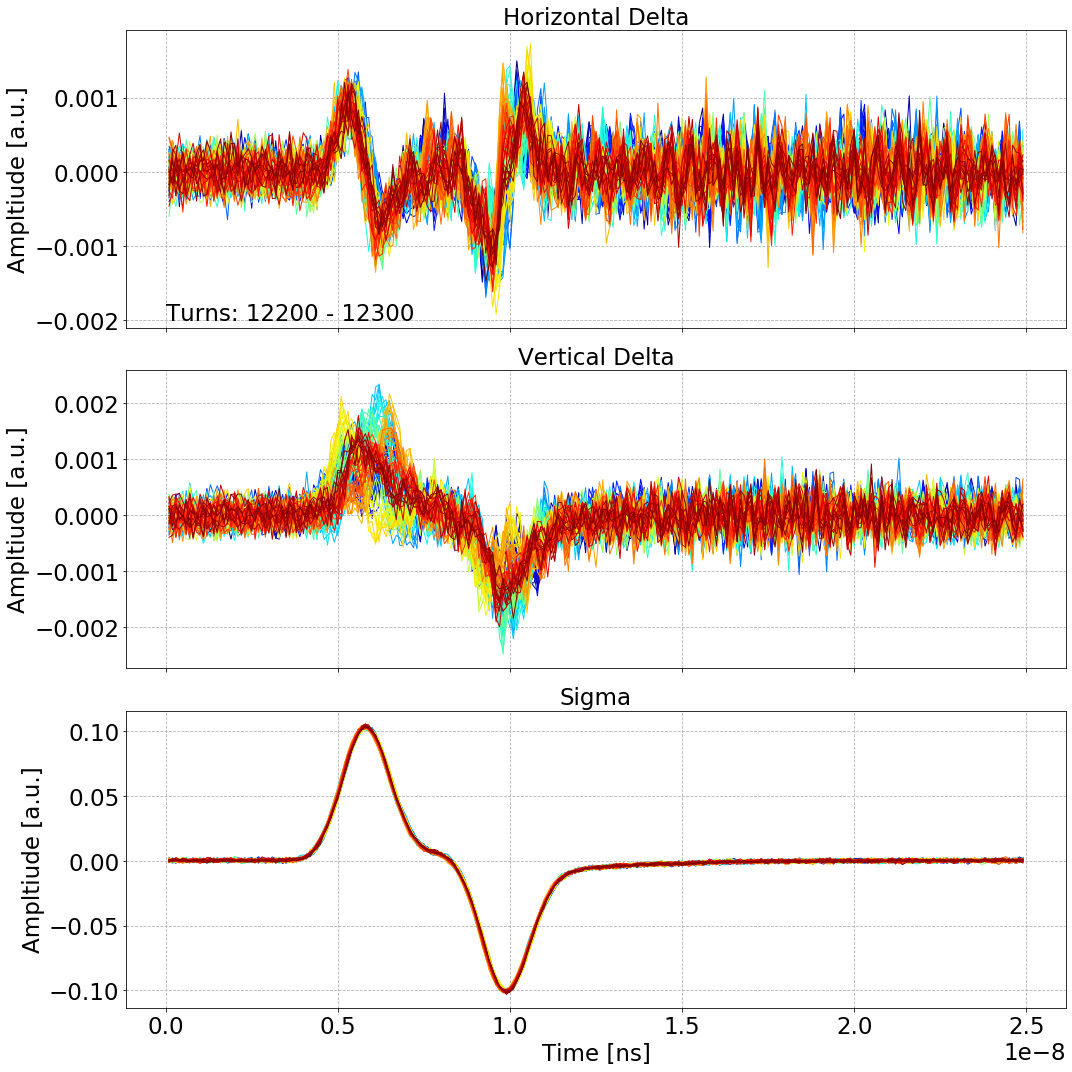

In [22]:
start, stop = 12200, 12300
colors = mpl.cm.jet(np.linspace(0, 1, stop-start)) # the color code indicates the number of turns
turns_list = list(range(n_populated_turns))

fig, ax = plt.subplots(3, 1, figsize=(15,15)) 
for i, turn in enumerate(turns_list[start:stop]):
    ax[0].plot(Delta_V_time, Delta_V_values[turn], c=colors[i])#,  aspect='auto')
    ax[1].plot(Delta_H_time, Delta_H_values[turn], c=colors[i])#,  aspect='auto')
    ax[2].plot(Sigma_time, Sigma_values[turn], c=colors[i])#,  aspect='auto')

ax[0].text(0, -0.002, f'Turns: {start} - {stop}', fontsize=23)
plt.setp(ax[0], xticklabels=[])
plt.setp(ax[1], xticklabels=[])
    
ax[0].grid(ls='--')
ax[1].grid(ls='--')
ax[2].grid(ls='--')

# Titles
ax[0].set_title('Horizontal Delta')
ax[1].set_title('Vertical Delta')
ax[2].set_title('Sigma')

# Axis Labels
ax[0].set_ylabel('Ampltiude [a.u.]')
ax[1].set_ylabel('Ampltiude [a.u.]')
ax[2].set_ylabel('Ampltiude [a.u.]')

ax[2].set_xlabel('Time [ns]')


ax[2].ticklabel_format(axis='x', style='', scilimits=(0,0))

plt.tight_layout()


savefig=False
if savefig:
    plt.savefig(f'{dataDir}HT_1D_{name[-19:-3]}.png', bbox_inches='tight')

In [23]:
mean_delta_ref = np.mean(Delta_V_values[turn_reference_start:turn_reference_stop], axis=0)
mean_sigma_ref = np.mean(Sigma_values[turn_reference_start:turn_reference_stop], axis=0)

mean_delta_meas = np.mean(Delta_V_values[turn_measurement_start:turn_measurement_stop], axis=0)
mean_sigma_meas = np.mean(Sigma_values[turn_measurement_start:turn_measurement_stop], axis=0)

Text(0, 0.5, 'Amplitude [a.u.]')

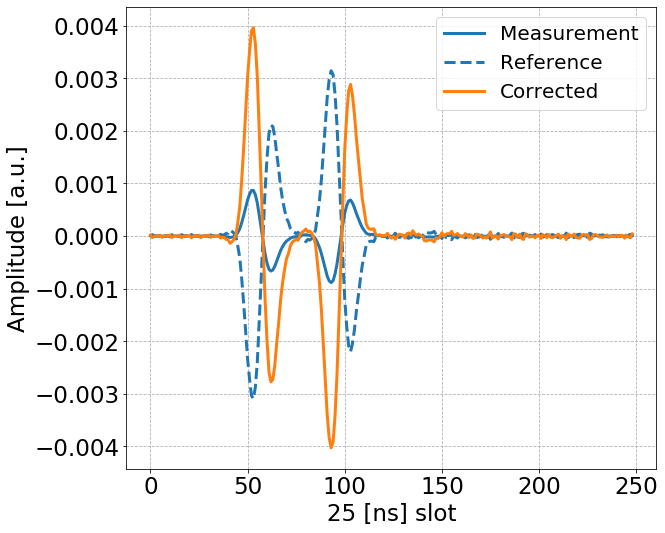

In [24]:
# Plot the reference, the measurment and the corrected signals
fig, ax = plt.subplots()

ax.plot(mean_delta_meas, lw=3, c='C0', label='Measurement')
ax.plot(mean_delta_ref, ls='--', lw=3, c='C0', label='Reference')
ax.plot(mean_delta_meas-mean_delta_ref, lw=3, c='C1', label='Corrected')

plt.legend(loc=0)
plt.grid(ls='--')
plt.xlabel('25 [ns] slot')
plt.ylabel('Amplitude [a.u.]')


savefig=False
if savefig:
    plt.savefig(f'{dataDir}HT_measures_vs_reference_vs_corrected_{name[-19:-3]}.png', bbox_inches='tight')

In [25]:
delta_0, sigma_0 = np.array([mean_delta_ref, mean_delta_meas]), np.array([mean_sigma_ref, mean_sigma_meas]) 

In [26]:
#sigma_0, delta_0 = calc_means(htf_0, N=2) # mean over 100 turns. N matters

In [27]:
crabwave, sigma = getHTtraces(sigma_0,  delta_0)

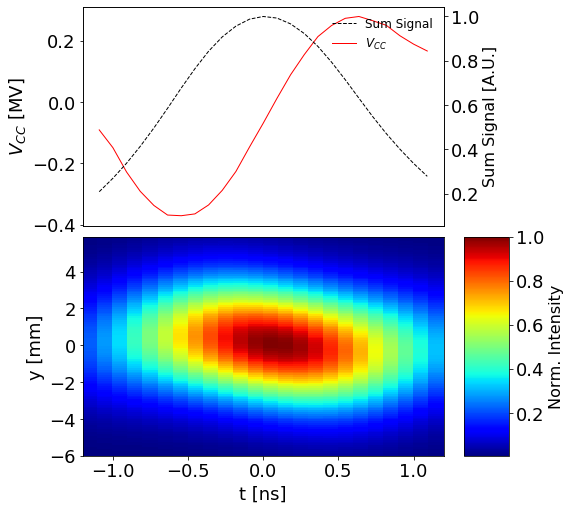

In [28]:
crabwave, sigma = getHTtraces(sigma_0,  delta_0)
x = np.arange(-1.2, 1.3, 0.1)
crabInterp = interp1d(x, crabwave, bounds_error=False, fill_value=0)
orbitResponse = getOrbitResponse()


p0 = [2000., 0., 0.18]
coeff, var_matrix = curve_fit(gauss, x, sigma, p0=p0)
    
def varFunc(y,z):
    return yGauss(y)*gauss(z, coeff[0], coeff[1], coeff[2])


yvals = np.arange(-6,6,0.1)

zvals = x
yy,zz = np.meshgrid(yvals,zvals)

aa = varFunc(yy-crabInterp(zz),zz)/(np.trapz(gauss(zvals, coeff[0], coeff[1], coeff[2]),x=zvals))


fig = plt.figure(figsize=(8,8))
gs = grd.GridSpec(2, 2, height_ratios=[10,10], width_ratios=[8,1], wspace=0.1)
ax1 = plt.subplot(gs[2])
cax = ax1.pcolormesh(zz, yy, aa/np.amax(aa), cmap = cm.jet)


colorax = plt.subplot(gs[3])
cbar = plt.colorbar(cax, cax=colorax)
cbar.set_label('Norm. Intensity', fontsize=16)
colorax.tick_params(axis='both', labelsize=18)
ax2 = plt.subplot(gs[0])
ax2.plot(zvals, -crabwave*26e9/(orbitResponse*1e9), color='r')
#ax2.plot(zvals, -crabwave*270e9/(orbitResponse*1e9), color='r')
    
ax2.axes.get_xaxis().set_visible(False)
ax22 = ax2.twinx()
ax22.plot(x, sigma/np.amax(sigma), color='k', linestyle='dashed', label='Sum Signal')
ax22.set_ylabel('Sum Signal [A.U.]', fontsize=16)
ax22.tick_params(axis='both', which='both', labelsize=18)
ax22.plot([0],[0.1],color='r', label=r'$V_{CC}$')
ax22.legend(loc=1, frameon=False, fontsize=12)
#ax22.set_ylim([0,1])

#ax2.set_ylim(-2.4,2.1)
ax1.set_xlabel('t [ns]', fontsize=18)
ax1.set_ylabel('y [mm]', fontsize=18)
ax2.set_ylabel(r'$V_{CC}\ \mathrm{[MV]}$', fontsize=18)
ax1.tick_params(axis='both', which='both', labelsize=18)
ax2.tick_params(axis='both', which='both', labelsize=18)
fig.subplots_adjust(left=0.16, hspace=0.05, top=0.905)
#plt.suptitle('Crabbing Voltage from Head-Tail Monitor \n' + unix2string(htf_0.acq_stamp/1e9)[:-7], fontsize=18)

savefig=False
if savefig:
    plt.savefig(f'{dataDir}HT_crabVoltage_{name[-19:-3]}.png', bbox_inches='tight')    

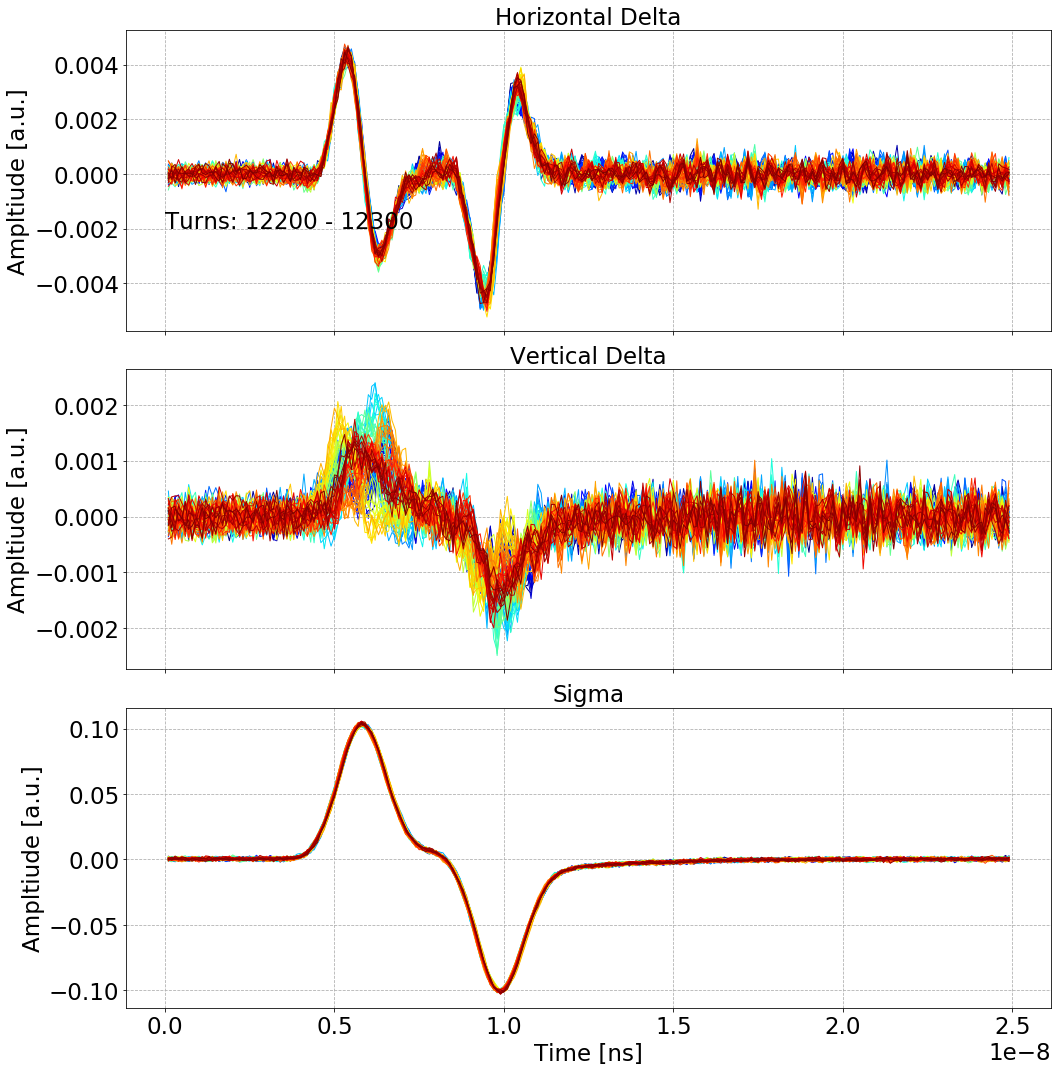

In [320]:
# Plot 1D output after removing the baseline (mean of reference signal)
start, stop = 12200, 12300
colors = mpl.cm.jet(np.linspace(0, 1, stop-start)) # the color code indicates the number of turns
turns_list = list(range(n_populated_turns))

fig, ax = plt.subplots(3, 1, figsize=(15,15)) 
for i, turn in enumerate(turns_list[start:stop]):
    ax[0].plot(Delta_V_time, Delta_V_values[turn]-mean_delta_V, c=colors[i])#,  aspect='auto')
    ax[1].plot(Delta_H_time, Delta_H_values[turn], c=colors[i])#,  aspect='auto')
    ax[2].plot(Sigma_time, Sigma_values[turn], c=colors[i])#,  aspect='auto')

ax[0].text(0, -0.002, f'Turns: {start} - {stop}', fontsize=23)
plt.setp(ax[0], xticklabels=[])
plt.setp(ax[1], xticklabels=[])
    
ax[0].grid(ls='--')
ax[1].grid(ls='--')
ax[2].grid(ls='--')

# Titles
ax[0].set_title('Horizontal Delta')
ax[1].set_title('Vertical Delta')
ax[2].set_title('Sigma')

# Axis Labels
ax[0].set_ylabel('Ampltiude [a.u.]')
ax[1].set_ylabel('Ampltiude [a.u.]')
ax[2].set_ylabel('Ampltiude [a.u.]')

ax[2].set_xlabel('Time [ns]')


ax[2].ticklabel_format(axis='x', style='', scilimits=(0,0))


plt.tight_layout()

